# Problem set 2

A lot of the phenomena around us or relationships of any kind may be mapped to networks. Often graphs, the mathematical objects, help structural and functional analysis of these networks.

In this problem set we are interested in the citation network. Visit [aMiner](https://aminer.org/citation) for input data.

## Problem 2.1

Reconstruct the scitation graphs based on these data. Analize those graphs. Besides the usual graph metrics for the _whole_ graph try to see if you can say something about temporal evolution.
Define various strategies for node removal and see how the _whole_ graph degrades.
Discuss what you find.

## Problem 2.2 (optional)

Design and implement a crawler to download meta information about articles. You may choose to query [scholar](https://scholar.google.com/) or [arXiv](https://arxiv.org/). The former indexes scientific articles, the latter gives open access to more than a million of e-prints in various fields of science.

Try to collect properties like:
* date of submission
* the list of articles cited
* the list of authors
* the field of science
* the title of the artice

Reconstruct the citation graph and carry out analisys as in Problemset 2.1. Discuss your findings.

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx

# Downloading data

In [2]:
!/bin/bash -c 'if [[ ! -d data ]]; then mkdir data; fi'
!/bin/bash -c 'if [[ ! -f data/citation-network1.zip ]]; then curl http://aminer.org/lab-datasets/citation/citation-network1.zip -o ./data/citation-network1.zip; fi'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0  5854k      0  0:00:22  0:00:22 --:--:-- 8619k


In [3]:
!/bin/bash -c 'if [[ ! -f data/outputacm.txt ]]; then cd data && unzip -o citation-network1.zip; fi'

Archive:  citation-network1.zip
  inflating: outputacm.txt           


In [4]:
!ls -lah data

total 484M
drwxrwxr-x 2 dnagy dnagy 4.0K Dec 11 22:39 .
drwxrwxr-x 8 dnagy dnagy 4.0K Dec 11 22:39 ..
-rw-rw-r-- 1 dnagy dnagy 127M Dec 11 22:39 citation-network1.zip
-rw-rw-r-- 1 dnagy dnagy 358M Apr 11  2010 outputacm.txt


In [5]:
"""
DATA FORMAT:
#* --- paperTitle
#@ --- Authors
#t ---- Year
#c  --- publication venue
#index 00---- index id of this paper
#% ---- the id of references of this paper (there are multiple lines, with each indicating a reference)
#! --- Abstract

The following is an example:

#*Information geometry of U-Boost and Bregman divergence
#@Noboru Murata,Takashi Takenouchi,Takafumi Kanamori,Shinto Eguchi
#t2004
#cNeural Computation
#index436405
#%94584
#%282290
#%605546
#%620759
#%564877
#%564235
#%594837
#%479177
#%586607
#!We aim at an extension of AdaBoost to U-Boost, in the paradigm to build a stronger classification machine from a set of weak learning machines. A geometric understanding of the Bregman divergence defined by a generic convex function U leads to the U-Boost method in the framework of information geometry extended to the space of the finite measures over a label set. We propose two versions of U-Boost learning algorithms by taking account of whether the domain is restricted to the space of probability functions. In the sequential step, we observe that the two adjacent and the initial classifiers are associated with a right triangle in the scale via the Bregman divergence, called the Pythagorean relation. This leads to a mild convergence property of the U-Boost algorithm as seen in the expectation-maximization algorithm. Statistical discussions for consistency and robustness elucidate the properties of the U-Boost methods based on a stochastic assumption for training data.
""";

In [6]:
TAG_TITLE='#*'
TAG_AUTHORS='#@'
TAG_YEAR='#t'
TAG_VENUE='#c'
TAG_IDX='#index'
TAG_REF='#%'
TAG_ABS='#!'

In [7]:
# Print first few lines from the downloaded data
datafile='./data/outputacm.txt'
lines = []
N=363 #2497 # process 2497 lines
with open(datafile, "r") as f:
    for idx, line in enumerate(f):
        if idx<N:
            lines.append(line)
        else:
            break
print(''.join(lines[-10:]))

#cPattern Recognition
#index53
#%159598
#%603894
#%586607
#%471174
#%87254
#%302739
#%449562
#!The polynomial classifier (PC) that takes the binomial terms of reduced subspace features as inputs has shown superior performance to multilayer neural networks in pattern classification. In this paper, we propose a class-specific feature polynomial classifier (CFPC) that extracts class-specific features from class-specific subspaces, unlike the ordinary PC that uses a class-independent subspace. The CFPC can be viewed as a hybrid of ordinary PC and projection distance method. The class-specific features better separate one class from the others, and the incorporation of class-specific projection distance further improves the separability. The connecting weights of CFPC are efficiently learned class-by-class to minimize the mean square error on training samples. To justify the promise of CFPC, we have conducted experiments of handwritten digit recognition and numeral string recognition on the

In [8]:
"""
What we see:
- the first line contains the number of records
- the records are indexed from 0
- the records are separated by a newline
""";

In [9]:
N_records = int(lines.pop(0))
N_records

629814

In [10]:
sample=''.join(lines)
records=sample.split('\n\n')
print(len(records))
print(records[0])

54
#*Automated Deduction in Geometry: 5th International Workshop, ADG 2004, Gainesville, FL, USA, September 16-18, 2004, Revised Papers (Lecture Notes in Computer ... / Lecture Notes in Artificial Intelligence)
#@Hoon Hong,Dongming Wang
#t2006
#c
#index0


In [11]:
class Node:
    def __init__(self, data):
        self.data = data
    def __hash__(self):
        return self.data[TAG_IDX]
def parse_record(r):
    rv = {
        TAG_TITLE: None,
        TAG_AUTHORS: None,
        TAG_YEAR: None,
        TAG_VENUE: None,
        TAG_IDX: None,
        TAG_REF: [],
        TAG_ABS: None
    }
    for k in r.split('\n'):
        if k.startswith(TAG_TITLE):
            rv[TAG_TITLE] = k.replace(TAG_TITLE, '')
        elif k.startswith(TAG_AUTHORS):
            rv[TAG_AUTHORS] = k.replace(TAG_AUTHORS, '')
        elif k.startswith(TAG_YEAR):
            rv[TAG_YEAR] = k.replace(TAG_YEAR, '')
        elif k.startswith(TAG_VENUE):
            rv[TAG_VENUE] = k.replace(TAG_VENUE, '')
        elif k.startswith(TAG_IDX):
            rv[TAG_IDX] = int(k.replace(TAG_IDX, ''))
        elif k.startswith(TAG_REF):
            rv[TAG_REF].append(int(k.replace(TAG_REF, '')))
        elif k.startswith(TAG_ABS):
            rv[TAG_ABS] = k.replace(TAG_ABS, '')
        pass
    return Node(data=rv)

In [12]:
"""
TODO: parse all nodes, then drop all nodes that are not referenced by any others
or are not referencing other nodes.
"""

'\nTODO: parse all nodes, then drop all nodes that are not referenced by any others\nor are not referencing other nodes.\n'

In [13]:
# Add all records to a graph
G = nx.Graph()
useful_indices = []

for record in records:
    node = parse_record(record)
    if node.data[TAG_REF] != []:
        G.add_node(node.data[TAG_IDX]) # Add only if has refs
        useful_indices.append(node.data[TAG_IDX])
        for ref in node.data[TAG_REF]:
            useful_indices.append(ref)
            G.add_node(ref)
            G.add_edge(node.data[TAG_IDX], ref)

print(useful_indices)

[5, 436405, 17, 357875, 214023, 317448, 319987, 334185, 95255, 294124, 96319, 610127, 24, 251778, 436906, 623227, 287885, 35, 247215, 618899, 53, 159598, 603894, 586607, 471174, 87254, 302739, 449562]


In [14]:
# Relabel nodes
G = nx.relabel_nodes(G, lambda x: hash(x))

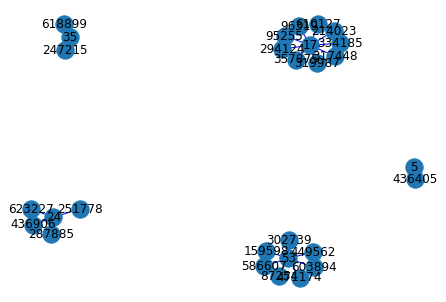

In [15]:
nx.draw(G, with_labels=True, edge_color='b')

In [17]:
comps = list(nx.connected_component_subgraphs(G))

AttributeError: module 'networkx' has no attribute 'connected_component_subgraphs'

In [ ]:
for comp in comps:
    plt.figure(figsize=(6,4), dpi=80)
    nx.draw(comp, with_labels=True, edge_color='b')

In [ ]:
# Add edges 
for n in enumerate(G.nodes()):
    print(n)

In [ ]:
G = nx.Graph()
G.add_node(node.data[TAG_IDX])
G.add_node(2)
G.add_edge(node.data[TAG_IDX],3)

nx.draw(G, with_labels=True, edge_color='b')